<a href="https://colab.research.google.com/github/ondraperny/BI-BPR-2019/blob/master/MURA_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mura dataset
Currently for testing purposes, just part of dataset is used. Specifically XR_HUMERUS data.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import keras.backend as k
from keras.preprocessing.image import ImageDataGenerator
import os
from glob import glob
%matplotlib inline

In [48]:
# Cloud run
from google.colab import drive
drive.mount('/content/drive')
PATH="/content/drive/My Drive/SKOLA/Bachelor_work/XR_HUMERUS/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Local run
# PATH="C:/DEV/Bak/XR_HUMERUS/"

##  Constants declaration

In [0]:
PATH_TRAIN = PATH + 'train'
PATH_VALID = PATH + 'valid'
IMG_SIZE=(224,224)
INPUT_SHAPE = (*IMG_SIZE, 3)
BATCH_SIZE = 128
NUMBER_CLASSES = 2
NUMBER_EPOCHS = 15

# constants below not currently used
NUMBER_STEPS_PER_EPOCH = 62
NUMBER_VALIDATION_STEPS = 62

## Data augmentation
Currently image augmentation will be done by parameters of ImageDataGenerator.
If in future this solution will be insufficient, I will change it.

In [0]:
def ImageDataGenerator_def():
  datagen = ImageDataGenerator(
    # featurewise_center=False,  # set input mean to 0 over the dataset
    # samplewise_center=False,  # set each sample mean to 0
    # featurewise_std_normalization=False,  # divide inputs by std of the dataset
    # samplewise_std_normalization=False,  # divide each input by its std
    # zca_whitening=False,  # apply ZCA whitening
    # zca_epsilon=1e-06,  # epsilon for ZCA whitening
    # rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    # # randomly shift images horizontally (fraction of total width)
    # width_shift_range=0.1,
    # # randomly shift images vertically (fraction of total height)
    # height_shift_range=0.1,
    # shear_range=0.,  # set range for random shear
    # zoom_range=0.,  # set range for random zoom
    # channel_shift_range=0.,  # set range for random channel shifts
    # # set mode for filling points outside the input boundaries
    # fill_mode='nearest',
    # cval=0.,  # value used for fill_mode = "constant"
    # horizontal_flip=True,  # randomly flip images
    # vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=1. / 255,
    # # set function that will be applied on each input
    # preprocessing_function=None,
    # # image data format, either "channels_first" or "channels_last"
    # data_format=None,
    # # fraction of images reserved for validation (strictly between 0 and 1)
    # validation_split=0.0
  )
  return datagen

def load_from_directory(dir_path):
  '''Load images from directory while transforming data (based on parameters),
  contain other parameters for data augmentation'''
  batches = data_generator.flow_from_directory(
    # path to target directory from which data will be loaded
    dir_path,
    # resize all input images to IMG_SIZE
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
  )
  return batches

In [52]:
data_generator = ImageDataGenerator_def()

train_batches = load_from_directory(PATH_TRAIN)
valid_batches = load_from_directory(PATH_VALID)

print("Found indices: ")
print(train_batches.class_indices)
# print(train_batches.class_indices)

Found 1272 images belonging to 2 classes.
Found 288 images belonging to 2 classes.
Found indices: 
{'train_negative': 0, 'train_positive': 1}


## Functions
Next block contains definitions of function for following code.

In [0]:
def label_to_string(label):
  '''Map label value to descriptive string'''
  if(label == 0):
    return "Negative"
  else:
    return "Positive"

def show_sample_images():
  '''Show one batch of training images (max 25 images)'''
  image_batch, label_batch = train_batches.next()
  plt.figure(figsize=(10,10))
  for n in range(min(len(image_batch), 25)):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(label_to_string(label_batch[n]))
    plt.axis('off')
  plt.show()

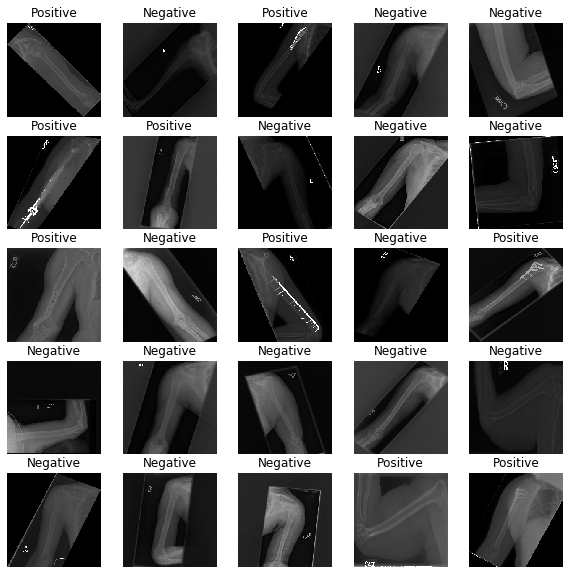

In [54]:
show_sample_images()

## Model definitions

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

def simple_deep_CNN():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same', input_shape=INPUT_SHAPE))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(NUMBER_CLASSES))
  model.add(Activation('softmax'))
  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model


def three_block_VGG():
  # '''Three Block VGG Model'''
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=INPUT_SHAPE))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

def model_def():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
  model.add(Flatten())
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model

In [69]:
model = three_block_VGG()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)           

In [15]:
model.fit_generator(train_batches,
                    steps_per_epoch= len(train_batches),
                    validation_data = valid_batches,
                    validation_steps = len(valid_batches),
                    epochs = NUMBER_EPOCHS)

Epoch 1/15





10/10 [==============================] - 112s 11s/step - loss: 0.7106 - acc: 0.5485 - val_loss: 0.7825 - val_acc: 0.5000
Epoch 2/15
10/10 [==============================] - 109s 11s/step - loss: 0.7010 - acc: 0.5584 - val_loss: 0.7190 - val_acc: 0.5104
Epoch 3/15
10/10 [==============================] - 112s 11s/step - loss: 0.6780 - acc: 0.5746 - val_loss: 0.6681 - val_acc: 0.5972
Epoch 4/15
10/10 [==============================] - 112s 11s/step - loss: 0.6511 - acc: 0.6135 - val_loss: 0.6625 - val_acc: 0.6354
Epoch 5/15
10/10 [==============================] - 112s 11s/step - loss: 0.6378 - acc: 0.6448 - val_loss: 0.6603 - val_acc: 0.6285
Epoch 6/15
10/10 [==============================] - 112s 11s/step - loss: 0.6208 - acc: 0.6613 - val_loss: 0.6548 - val_acc: 0.6146
Epoch 7/15
10/10 [==============================] - 112s 11s/step - loss: 0.6225 - acc: 0.6493 - val_loss: 0.6693 - val_acc: 0.5556
Epoch 8/15
10/10 [==============================] - 112s 11s/step - los

In [0]:
len(train_batches)